# Calculate SWE at Watershed Scale:

In [97]:
import pandas as pd
import numpy as np
import rioxarray as rxr
import xarray as xr
import matplotlib.pyplot as plt
import altair as alt
import geopandas as gpd
import pickle

In [98]:
station_clusters = pickle.load(open('../data/combined_snotel_cdec/station_clusters.pkl', 'rb'))

In [40]:
riogrande = rxr.open_rasterio('../data/aso_lidar/riogrande_lidar/ASO_50M_SWE_USCORG_20150407.tif', mask_and_scale=True).squeeze()

In [14]:
clusters = gpd.read_file('../data/cluster_polygons.geojson')

In [3]:
riogrande.rio.crs

CRS.from_epsg(32613)

In [17]:
clusters

,date,cluster,geometry
0,2017,0.0,"POLYGON ((-109.88840 32.67118, -109.88840 32.7..."
1,2017,0.0,"POLYGON ((-108.60836 33.24006, -108.60836 33.2..."
2,2017,0.0,"POLYGON ((-108.71503 33.24006, -108.71503 33.3..."
3,2017,0.0,"POLYGON ((-105.83493 33.34673, -105.83493 33.4..."
4,2017,0.0,"POLYGON ((-109.39060 33.56006, -109.39060 33.5..."
...,...,...,...
3123,2017,2.0,"POLYGON ((-115.47080 48.49334, -115.47080 48.5..."
3124,2017,4.0,"POLYGON ((-114.97300 48.49334, -114.97300 48.5..."
3125,2017,4.0,"POLYGON ((-115.04412 48.95556, -115.04412 48.9..."
3126,2017,2.0,"POLYGON ((-114.68855 43.58669, -114.68855 43.6..."


Steps for watershed scale analysis:  
* start with Rio Grande or Conejos in 2016
* ~~Create polygon from raster~~
* clip reanalysis to raster extent
* calculate mean and stdev at each grid cell in the polygon  
* pull mean snv from within-watershed snotel
* calculate swe for each grid cell
* difference with the swe reanalysis data from april 1, 2016
* reproject and scale the 2016 aso data to match reanalysis (how do I make the grid cells align? reproject match?)
* difference from the aso data
* calculate metrics and plot difference maps

In [99]:
from matplotlib.colors import LinearSegmentedColormap
colors1=['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00'] #,'#ffff33'
cmap1 = LinearSegmentedColormap.from_list('clusters', colors1)
colors2=['#ff7f00','#4daf4a','#e41a1c','#984ea3','#377eb8'] #,'#ffff33'
cmap2 = LinearSegmentedColormap.from_list('clusters', colors2)

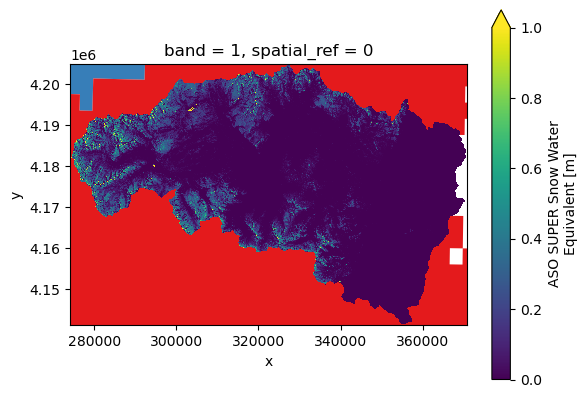

In [108]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
riogrande.plot(ax=ax, vmin=0,vmax=1)


In [38]:
conejos = rxr.open_rasterio('../data/aso_lidar/conejos_lidar/ASO_50M_SWE_USCOCJ_20160403.tif', mask_and_scale=True).squeeze()

In [32]:
conejos.rio.crs

CRS.from_epsg(32613)

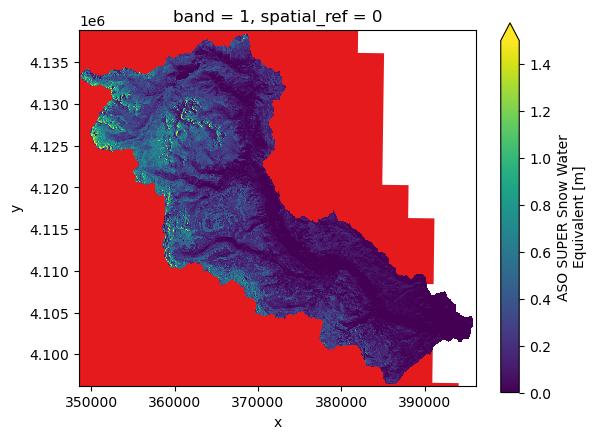

In [29]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
conejos.plot(ax=ax, vmin=0,vmax=1.5)

(4100000.0, 4210000.0)

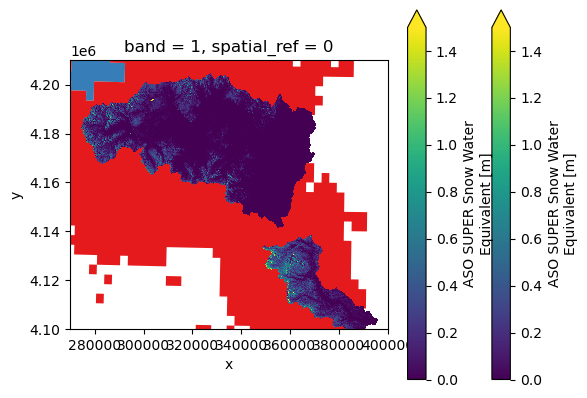

In [42]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
riogrande.plot(ax=ax, vmin=0,vmax=1.5)
conejos.plot(ax=ax, vmin=0,vmax=1.5)

ax.set_xlim(270000, 400000)
ax.set_ylim(4100000, 4210000)

In [44]:
crested_butte = rxr.open_rasterio('../data/aso_lidar/crested_butte_lidar/ASO_50M_SWE_USCOCB_20160404.tif', mask_and_scale=True).squeeze()

In [45]:
crested_butte.rio.crs

CRS.from_epsg(32613)

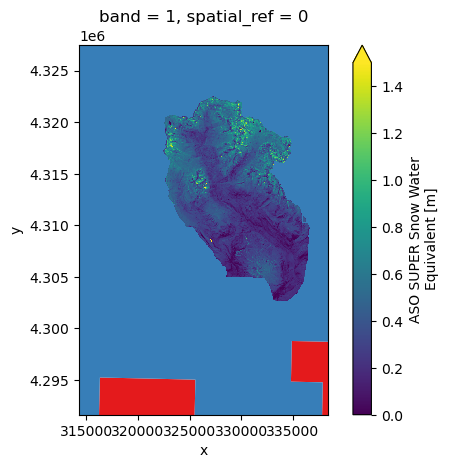

In [46]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
crested_butte.plot(ax=ax, vmin=0,vmax=1.5)
# riogrande.plot(ax=ax, vmin=0,vmax=1.5)
# conejos.plot(ax=ax, vmin=0,vmax=1.5)

# ax.set_xlim(270000, 400000)
# ax.set_ylim(4100000, 4210000)

(4100000.0, 4330000.0)

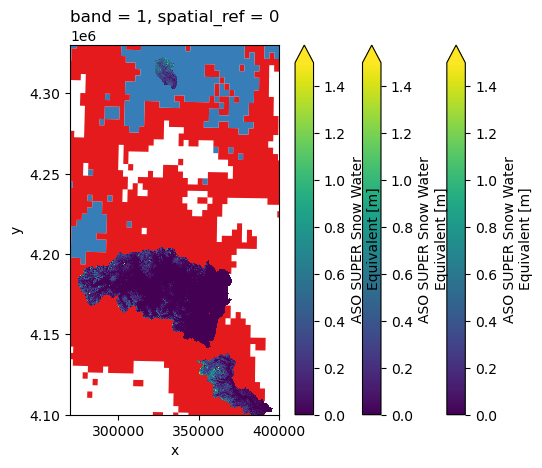

In [47]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
crested_butte.plot(ax=ax, vmin=0,vmax=1.5)
riogrande.plot(ax=ax, vmin=0,vmax=1.5)
conejos.plot(ax=ax, vmin=0,vmax=1.5)

ax.set_xlim(270000, 400000)
ax.set_ylim(4100000, 4330000)

In [49]:
east_river = rxr.open_rasterio('../data/aso_lidar/east_river_lidar/ASO_50M_SWE_USCOGE_20190407.tif', mask_and_scale=True).squeeze()

In [50]:
east_river.rio.crs

CRS.from_epsg(32613)

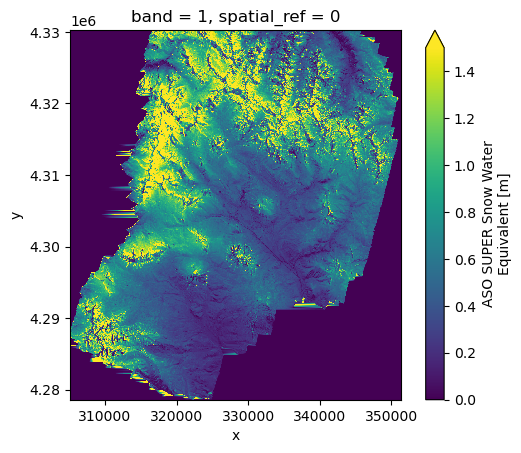

In [51]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
east_river.plot(ax=ax, vmin=0,vmax=1.5)

(4100000.0, 4330000.0)

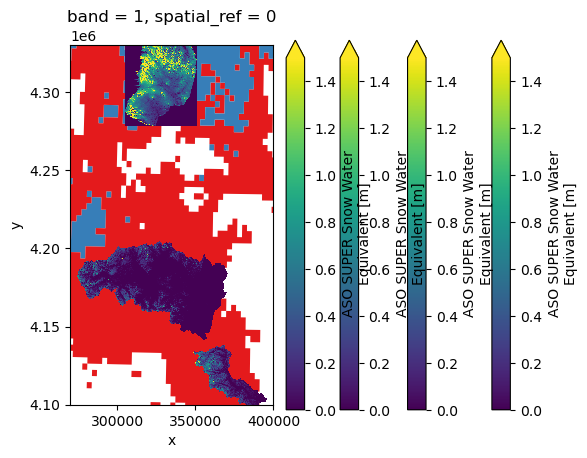

In [53]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
crested_butte.plot(ax=ax, vmin=0,vmax=1.5)
riogrande.plot(ax=ax, vmin=0,vmax=1.5)
conejos.plot(ax=ax, vmin=0,vmax=1.5)
east_river.plot(ax=ax, vmin=0,vmax=1.5)

ax.set_xlim(270000, 400000)
ax.set_ylim(4100000, 4330000)

In [54]:
taylor_river = rxr.open_rasterio('../data/aso_lidar/taylor_river_lidar/ASO_50M_SWE_USCOGT_20180330.tif', mask_and_scale=True).squeeze()

In [55]:
taylor_river.rio.crs

CRS.from_epsg(32613)

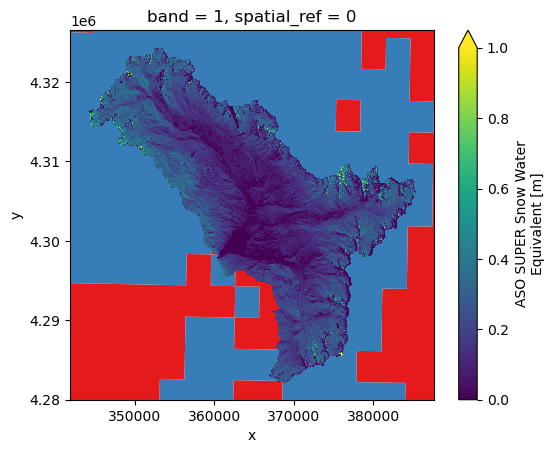

In [95]:
fig, ax = plt.subplots()
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
taylor_river.plot(ax=ax, vmin=0,vmax=1)

In [66]:
unc = rxr.open_rasterio('../data/aso_lidar/uncompaghre_lidar/ASO_50M_SWE_USCOUB_20140320.tif', mask_and_scale=True).squeeze()

In [77]:
unc.rio.write_crs('epsg:32613')

<xarray.DataArray (y: 698, x: 700)>
[488600 values with dtype=float32]
Coordinates:
    band         int64 1
  * x            (x) float64 2.397e+05 2.398e+05 ... 2.746e+05 2.747e+05
  * y            (y) float64 4.232e+06 4.232e+06 ... 4.197e+06 4.197e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:        Area
    TIFFTAG_XRESOLUTION:  1
    TIFFTAG_YRESOLUTION:  1

(4000000.0, 5000000.0)

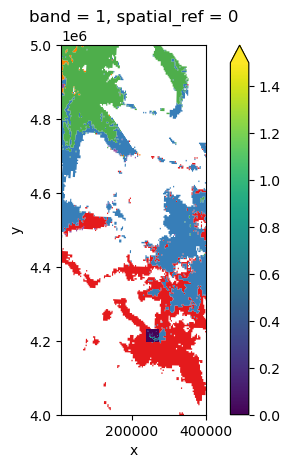

In [81]:
fig, ax = plt.subplots()

clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
unc.rio.write_crs('epsg:32613').plot(ax=ax, vmin=0,vmax=1.5)
ax.set_xlim(10000, 400000)
ax.set_ylim(4000000,5000000)

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

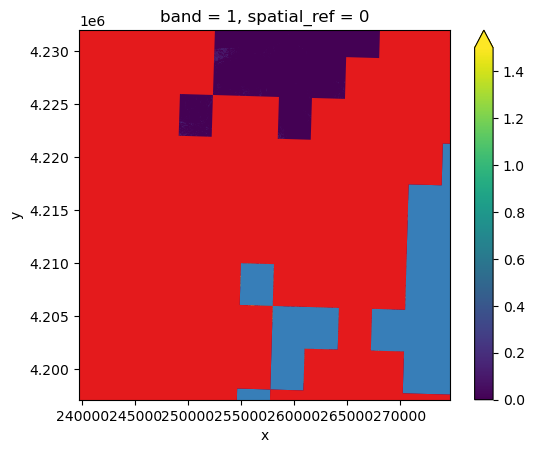

In [86]:
fig, ax = plt.subplots()
unc.rio.write_crs('epsg:32613').plot(ax=ax, vmin=0,vmax=1.5)
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))


In [67]:
aspen = rxr.open_rasterio('../data/aso_lidar/aspen_lidar/ASO_50M_SWE_USCOCM_20190407.tif', mask_and_scale=True).squeeze()

In [69]:
aspen.rio.crs

CRS.from_epsg(32613)

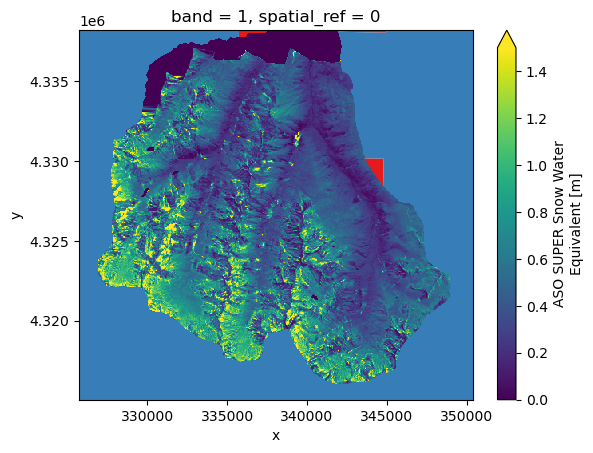

In [107]:
fig, ax = plt.subplots()

clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
aspen.plot(ax=ax, vmin=0,vmax=1.5)

(4100000.0, 4500000.0)

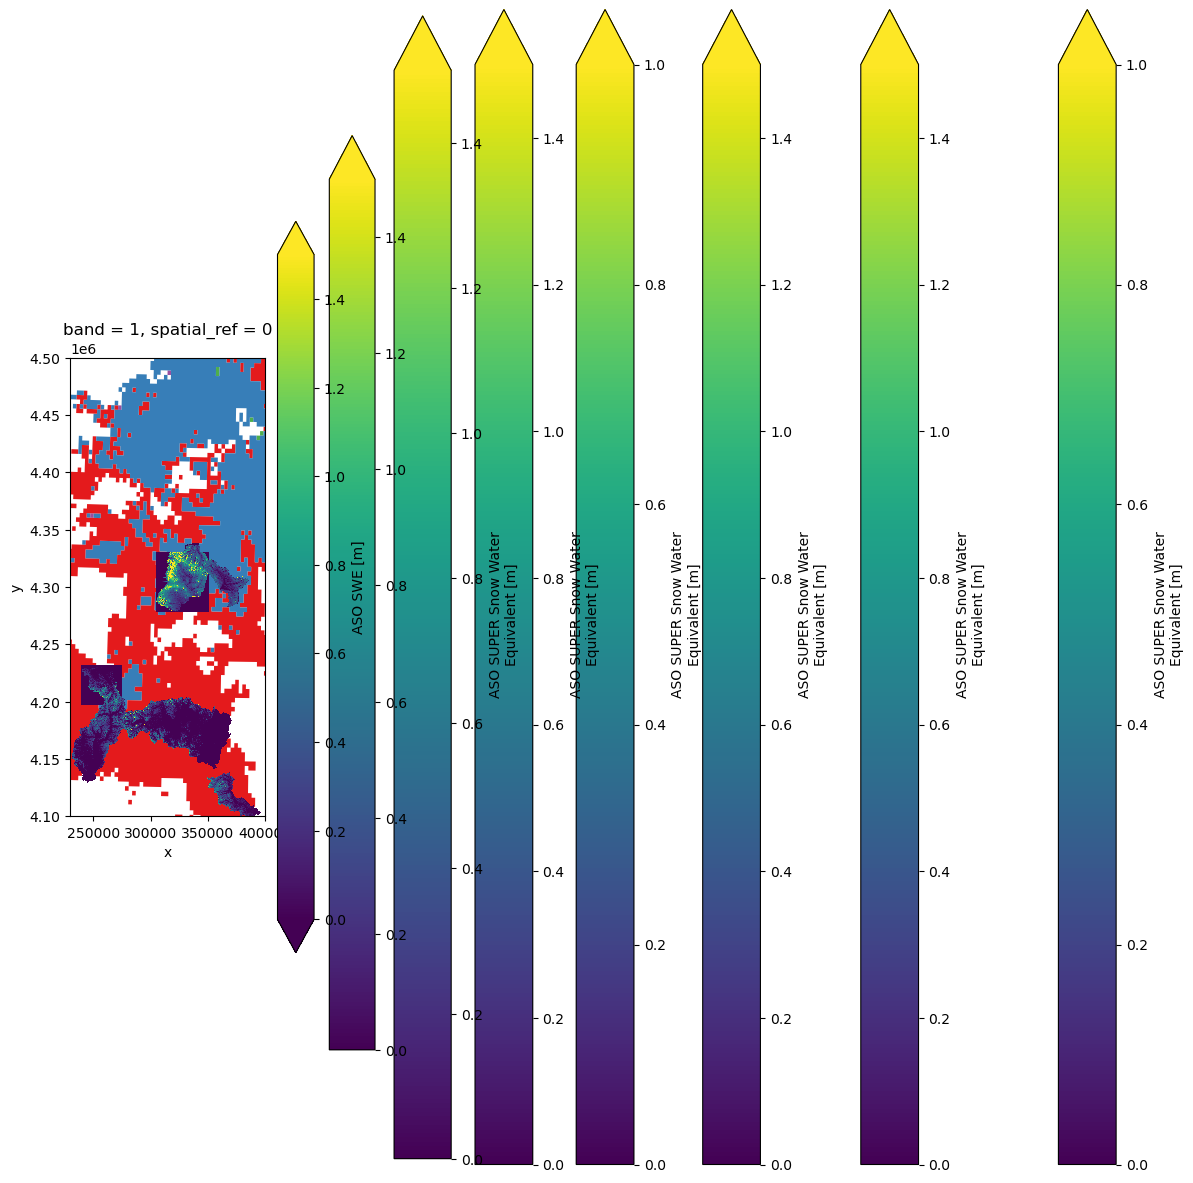

In [93]:
fig, ax = plt.subplots(figsize=(15,15))
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
riogrande.plot(ax=ax, vmin=0,vmax=1)
conejos.plot(ax=ax, vmin=0,vmax=1.5)
east_river.plot(ax=ax, vmin=0,vmax=1.5)
taylor_river.plot(ax=ax, vmin=0,vmax=1)
crested_butte.plot(ax=ax, vmin=0,vmax=1.5)
aspen.plot(ax=ax, vmin=0,vmax=1.5)
unc.rio.write_crs('epsg:32613').plot(ax=ax, vmin=0,vmax=1.5)
animas.plot(ax=ax, vmin=0,vmax=1.5)

ax.set_xlim(230000, 400000)
ax.set_ylim(4100000, 4500000)

In [89]:
animas = rxr.open_rasterio('../data/aso_lidar/animas_lidar/ASO_Animas_Mosaic_2021Apr19_swe_50m.tif', mask_and_scale=True).squeeze()

In [90]:
animas.rio.crs

CRS.from_epsg(32613)

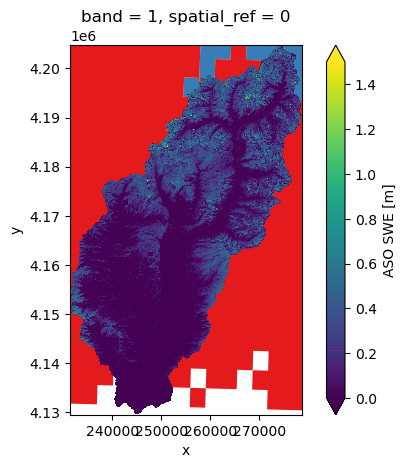

In [92]:
fig, ax = plt.subplots()

clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
animas.plot(ax=ax, vmin=0,vmax=1.5)

In [102]:
station_clusters.head(2)

,name,network,elevation_m,geometry,cluster_anom
code,,,,,
301_CA_SNTL,Adin Mtn,SNOTEL,1886.712036,POINT Z (-120.79192 41.23583 1886.71204),3
302_OR_SNTL,Aneroid Lake #2,SNOTEL,2255.520020,POINT Z (-117.19258 45.21328 2255.52002),0


(4100000.0, 4500000.0)

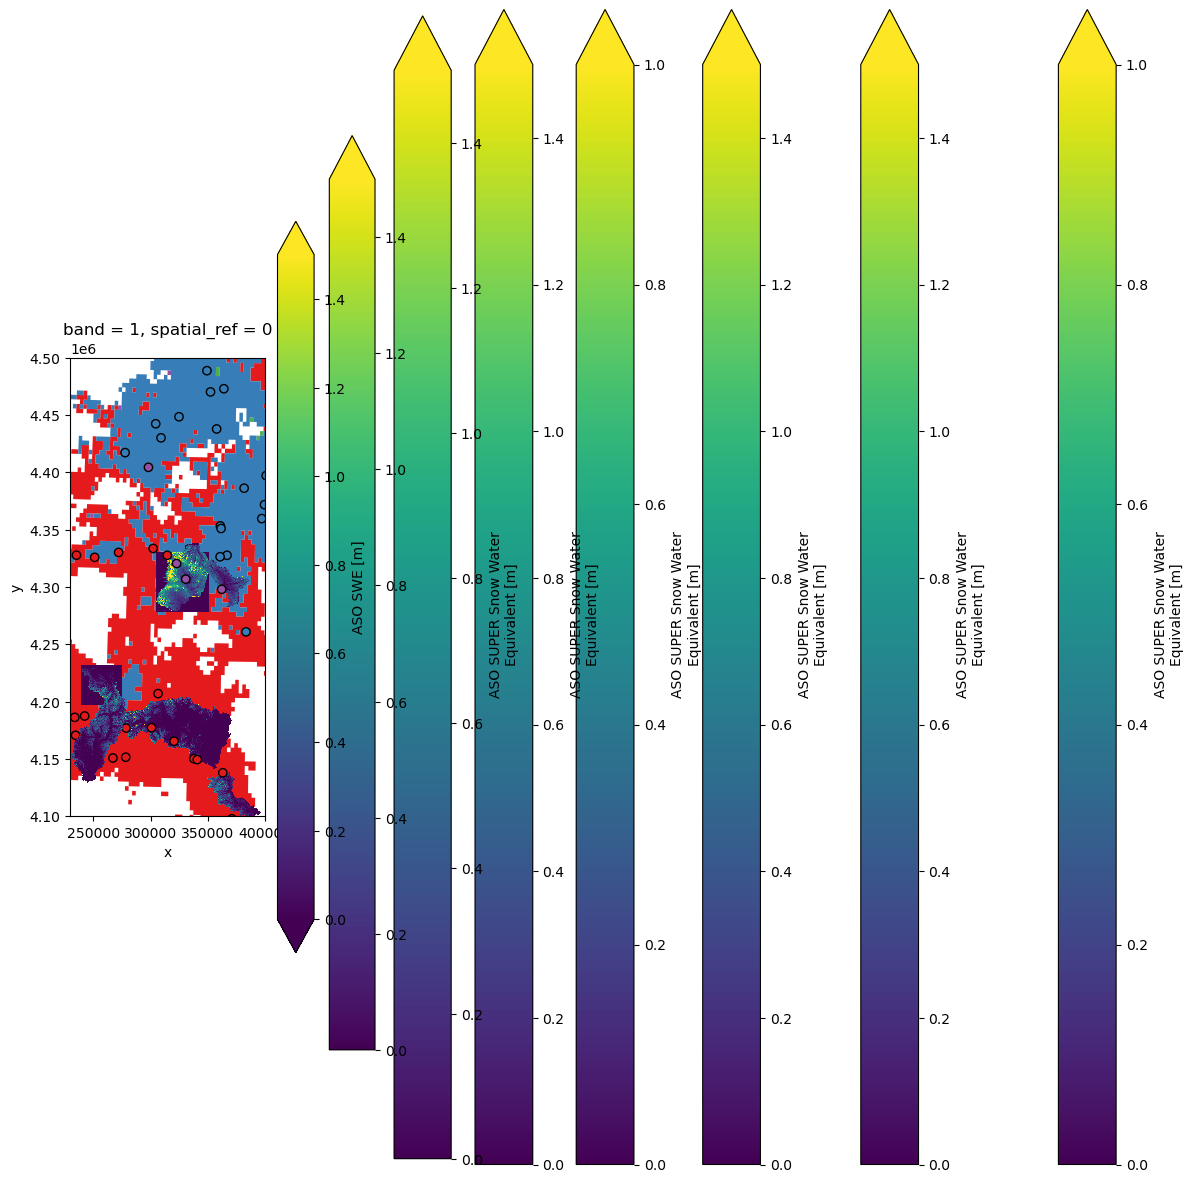

In [106]:
fig, ax = plt.subplots(figsize=(15,15))
clusters.to_crs('epsg:32613').plot(ax=ax, column = 'cluster', cmap = plt.get_cmap(cmap1, 6))
riogrande.plot(ax=ax, vmin=0,vmax=1)
conejos.plot(ax=ax, vmin=0,vmax=1.5)
east_river.plot(ax=ax, vmin=0,vmax=1.5)
taylor_river.plot(ax=ax, vmin=0,vmax=1)
crested_butte.plot(ax=ax, vmin=0,vmax=1.5)
station_clusters.to_crs('epsg:32613').plot(ax=ax, column='cluster_anom', edgecolor='k', cmap=cmap2)
aspen.plot(ax=ax, vmin=0,vmax=1.5)
unc.rio.write_crs('epsg:32613').plot(ax=ax, vmin=0,vmax=1.5)
animas.plot(ax=ax, vmin=0,vmax=1.5)

ax.set_xlim(230000, 400000)
ax.set_ylim(4100000, 4500000)